In [5]:
# Import necessary libraries
import os
import numpy as np
import librosa
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Function to calculate the power spectrum
def calculate_power_spectra(signal):
    """Calculate the power spectrum of a signal using FFT."""
    fft_signal = np.fft.fft(signal)
    power_spectrum = np.abs(fft_signal) ** 2
    return power_spectrum

# Function to calculate SNR
def calculate_snr(clean_signals, noisy_signal):
    """Calculate the average spectral SNR using multiple clean signals."""
    min_length = min(min(len(sig) for sig in clean_signals), len(noisy_signal))
    noisy_signal = noisy_signal[:min_length]
    snrs = []
    for clean_signal in clean_signals:
        clean_signal = clean_signal[:min_length]
        power_spectrum_clean = calculate_power_spectra(clean_signal)
        power_spectrum_noisy = calculate_power_spectra(noisy_signal)
        
        # Avoid division by zero and negative values in SNR computation
        power_spectrum_noisy[power_spectrum_noisy <= 0] = 1e-10
        power_spectrum_clean[power_spectrum_clean <= 0] = 1e-10

        snr_spectrum = 10 * np.log10(power_spectrum_clean / power_spectrum_noisy)
        snrs.append(np.mean(snr_spectrum))
    return np.mean(snrs)

# Function to calculate SNRs for all signals in directories
def calculate_all_snrs(clean_signals_directory, noisy_signals_directory):
    """Calculate SNRs for all .wav files in a given directory with multiple clean signals."""
    snrs = []
    filenames = []

    clean_signals = []
    for clean_filename in os.listdir(clean_signals_directory):
        if clean_filename.endswith(".wav"):
            full_clean_path = os.path.join(clean_signals_directory, clean_filename)
            try:
                clean_signal, sr_clean = librosa.load(full_clean_path, sr=None)
                clean_signals.append(clean_signal)
            except Exception as e:
                print(f"Failed to process {clean_filename}: {e}")

    for filename in os.listdir(noisy_signals_directory):
        if filename.endswith(".wav"):
            full_path = os.path.join(noisy_signals_directory, filename)
            try:
                noisy_signal, sr_noisy = librosa.load(full_path, sr=None)
                snr = calculate_snr(clean_signals, noisy_signal)
                snrs.append(snr)
                filenames.append(filename)
            except Exception as e:
                print(f"Failed to process {filename}: {e}")
    return snrs, filenames

# Function to plot SNRs
def plot_all_snrs(all_snrs, labels, title):
    """Plot all SNR distributions on a single axis with custom x-axis labels."""
    plt.figure(figsize=(12, 6))  # Adjust size as needed
    # Plot all SNRs on the same axes
    positions = range(1, len(all_snrs) + 1)  # Position each box plot
    plt.boxplot(all_snrs, vert=True, patch_artist=True, positions=positions)
    
    # Set x-axis labels
    plt.xticks(positions, labels)  # Set custom labels for each boxplot
    plt.title(title)
    plt.ylabel("SNR (dB)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot contour of SNR
def plot_snr_contour(snr_dict, title):
    """Plot a 2D contour map of mean SNR values with smooth interpolation."""
    # Create sorted lists of heights and custom mapping for distances with 'Baseline' represented by a specific value
    heights = sorted(snr_dict['Baseline'].keys())
    distances = sorted([key for key in snr_dict.keys() if key != 'Baseline'])
    distance_values = [1.7647] + [float(d) for d in distances]  # Replace distances with numerical values as needed

    # Preparing data for interpolation
    points = []  # (distance, height) pairs
    values = []  # SNR values
    for i, distance in enumerate(['Baseline'] + distances):
        for j, height in enumerate(heights):
            if snr_dict[distance][height]:
                mean_snr = np.mean(snr_dict[distance][height])
                points.append((distance_values[i], height))
                values.append(mean_snr)

    # Converting lists to numpy arrays
    points = np.array(points)
    values = np.array(values)

    # Create grid data for interpolation
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(distance_values), max(distance_values), 100),
        np.linspace(min(heights), max(heights), 100)
    )

    # Interpolate using griddata
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

    # Plotting the contour plot
    plt.figure(figsize=(10, 8))
    contourf = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='plasma')
    plt.colorbar(contourf, label='Mean SNR (dB)')
    plt.title(title)
    plt.xlabel('Arm Length [x/R]')
    plt.ylabel('Height [y/R]')
    plt.grid(True)

    # Optional: Add contour lines to highlight levels
    plt.contour(grid_x, grid_y, grid_z, levels=20, colors='k', linestyles='solid', linewidths=0.3)

    plt.show()

# Function to plot 3D surface of SNR
def plot_snr_surface(snr_dict, title):
    """Plot a 3D surface map of mean SNR values with smooth interpolation."""
    # Create sorted lists of heights and custom mapping for distances with 'Baseline' represented by a specific value
    heights = sorted(snr_dict['Baseline'].keys())
    distances = sorted([key for key in snr_dict.keys() if key != 'Baseline'])
    distance_values = [1.7647] + [float(d) for d in distances]  # Replace distances with numerical values as needed

    # Preparing data for interpolation
    points = []  # (distance, height) pairs
    values = []  # SNR values
    for i, distance in enumerate(['Baseline'] + distances):
        for j, height in enumerate(heights):
            if snr_dict[distance][height]:
                mean_snr = np.mean(snr_dict[distance][height])
                points.append((distance_values[i], height))
                values.append(mean_snr)

    # Converting lists to numpy arrays
    points = np.array(points)
    values = np.array(values)

    # Create grid data for interpolation
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(distance_values), max(distance_values), 100),
        np.linspace(min(heights), max(heights), 100)
    )

    # Interpolate using griddata
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

    # Set up a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='plasma', edgecolor='none')
    fig.colorbar(surf, ax=ax, label='Mean SNR (dB)', shrink=0.5, aspect=5)

    ax.set_title(title)
    ax.set_xlabel('Arm Length [x/R]')
    ax.set_ylabel('Height [y/R]')
    ax.set_zlabel('Mean SNR (dB)')

    plt.show()

# Function to run the analysis and plot results
def newfunc():
    """
    This function will plot the recordings from 4th June 2024.
    """

    heights = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 3.3, 3.6, 4, 4.3, 4.6, 5]  # Heights to process
    distances = [2, 2.3, 2.6, 3, 3.3, 3.6, 4]
    labels_heights = [f"{height} [y/R]" for height in heights]  # Custom labels for each boxplot
    labels_distances = ['Baseline'] + [f"{distance} [x/R]" for distance in distances]

    snr_dict = {distance: {height: [] for height in heights} for distance in distances}
    snr_dict['Baseline'] = {height: [] for height in heights}

    clean_signal_directory = "Final_RECORDINGS/Final_Recordings_4Jun/Clean_Keywords/"

    for height in heights:
        # first process original arm length
        noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/ArmOrig/"
        snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
        snr_dict['Baseline'][height] = snrs
        print(f"Processed {len(snrs)} files for height {height} and original arm length")
        for distance in distances:
            try:
                noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/Arm{distance}/"
                snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
                snr_dict[distance][height] = snrs
                print(f"Processed {len(snrs)} files for height {height} and arm length {distance}")
            except Exception as e:
                print(f"Failed to process height {height} and arm length {distance}: {e}")

    # Now we plot the SNR distributions
    # First, plot the SNR distributions for each height, varying arm length

    for height in heights:
        snrs = [snr_dict['Baseline'][height]] + [snr_dict[distance][height] for distance in distances]
        plot_all_snrs(snrs, labels_distances, f"SNR Distribution for Height {height} [y/R]")
    
    # Next, plot the SNR distributions for each arm length, varying height
    # first the original arm length
    snrs = [snr_dict['Baseline'][height] for height in heights]
    plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Original Arm Length x/R")
    for distance in distances:
        snrs = [snr_dict[distance][height] for height in heights]
        plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Arm Length {distance} [x/R]")

    # Finally, plot a heatmap of mean SNR values
    plot_snr_contour(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights")
    plot_snr_surface(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights")



Processed 7 files for height 0 and original arm length
Processed 8 files for height 0 and arm length 2
Processed 8 files for height 0 and arm length 2.3
Processed 7 files for height 0 and arm length 2.6
Processed 7 files for height 0 and arm length 3
Processed 7 files for height 0 and arm length 3.3
Processed 11 files for height 0 and arm length 3.6
Processed 15 files for height 0 and arm length 4
Processed 7 files for height 0.3 and original arm length
Processed 7 files for height 0.3 and arm length 2
Processed 7 files for height 0.3 and arm length 2.3
Processed 7 files for height 0.3 and arm length 2.6
Processed 7 files for height 0.3 and arm length 3
Processed 7 files for height 0.3 and arm length 3.3
Processed 10 files for height 0.3 and arm length 3.6
Processed 15 files for height 0.3 and arm length 4
Processed 7 files for height 0.6 and original arm length
Processed 12 files for height 0.6 and arm length 2
Processed 7 files for height 0.6 and arm length 2.3
Processed 7 files for 

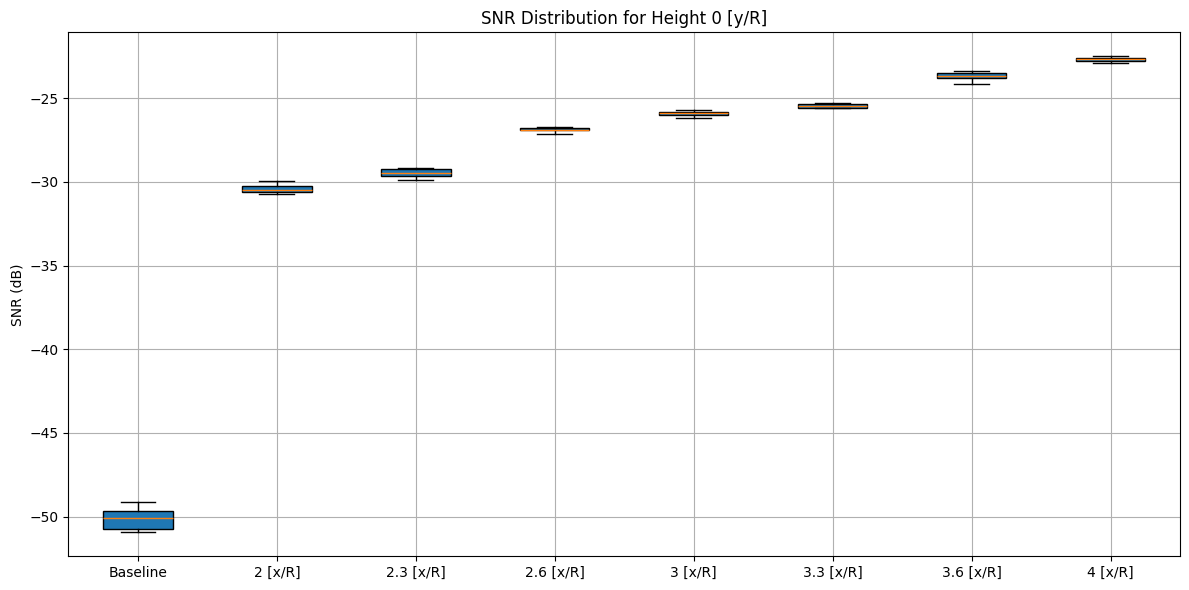

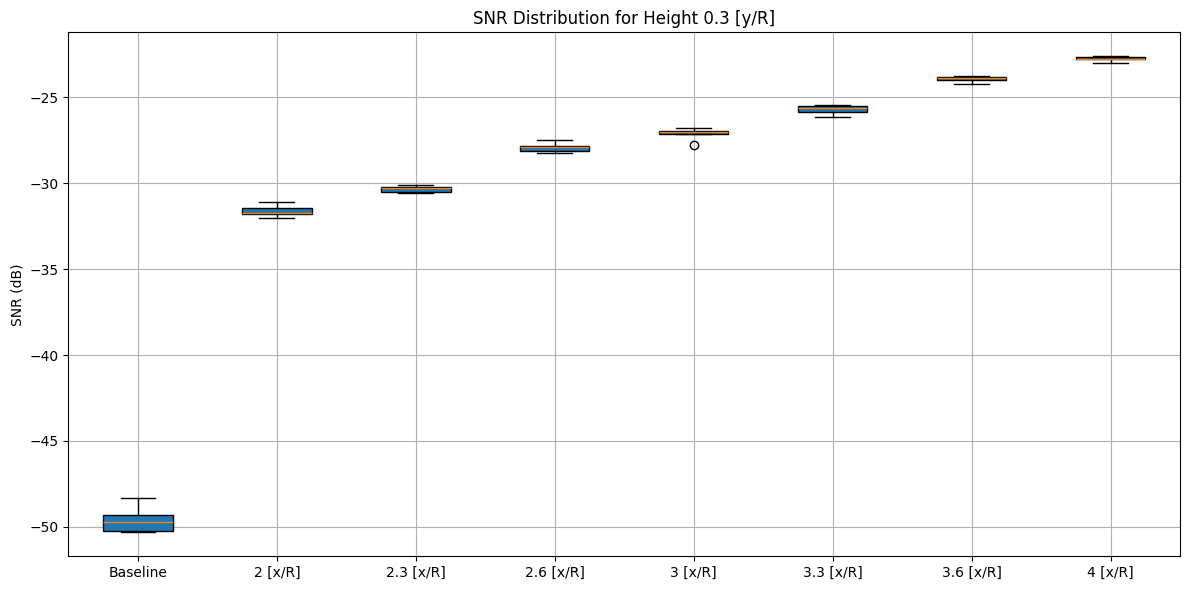

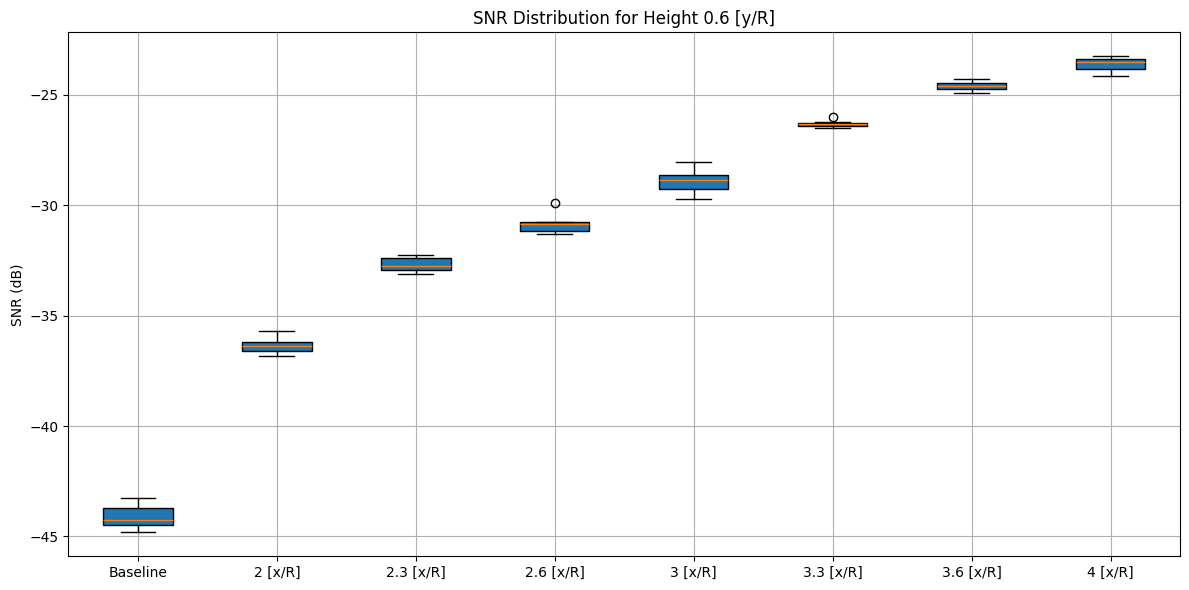

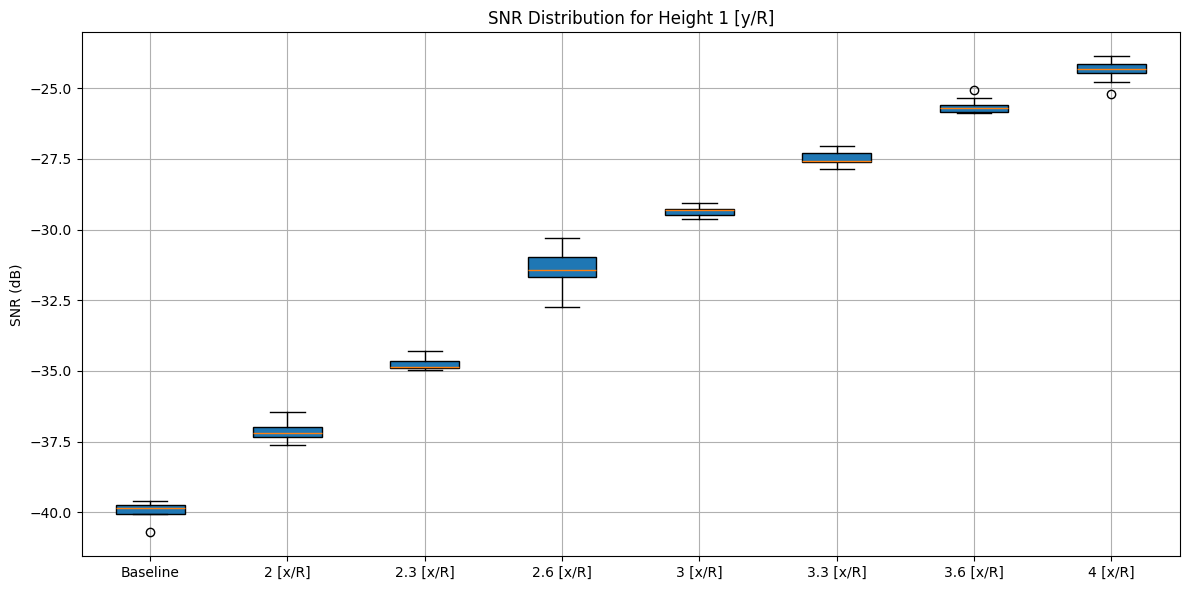

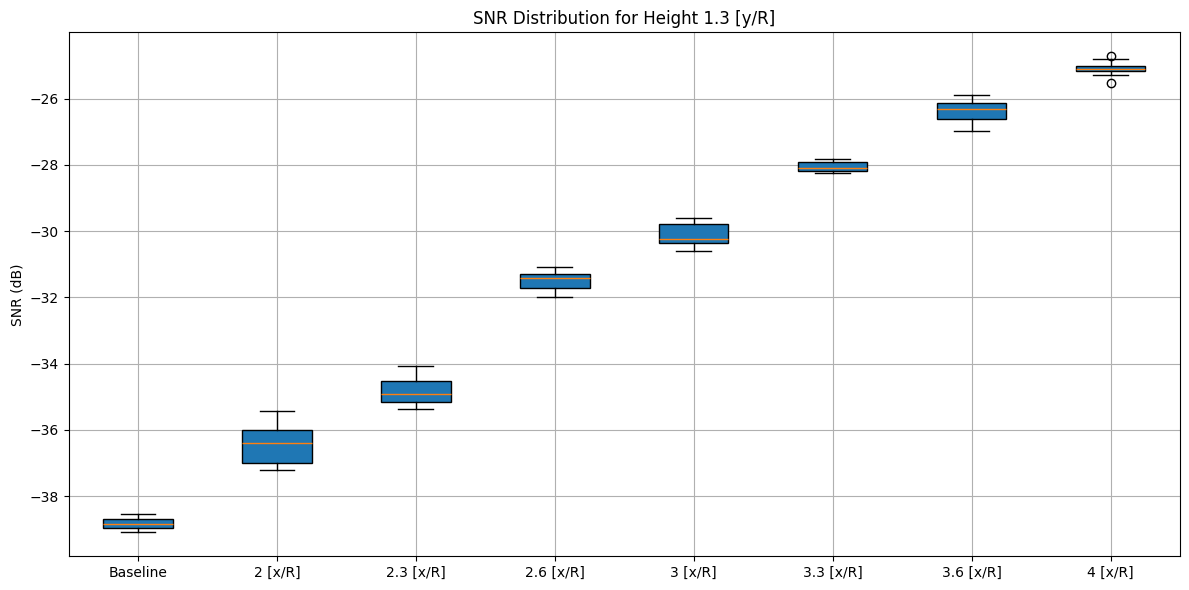

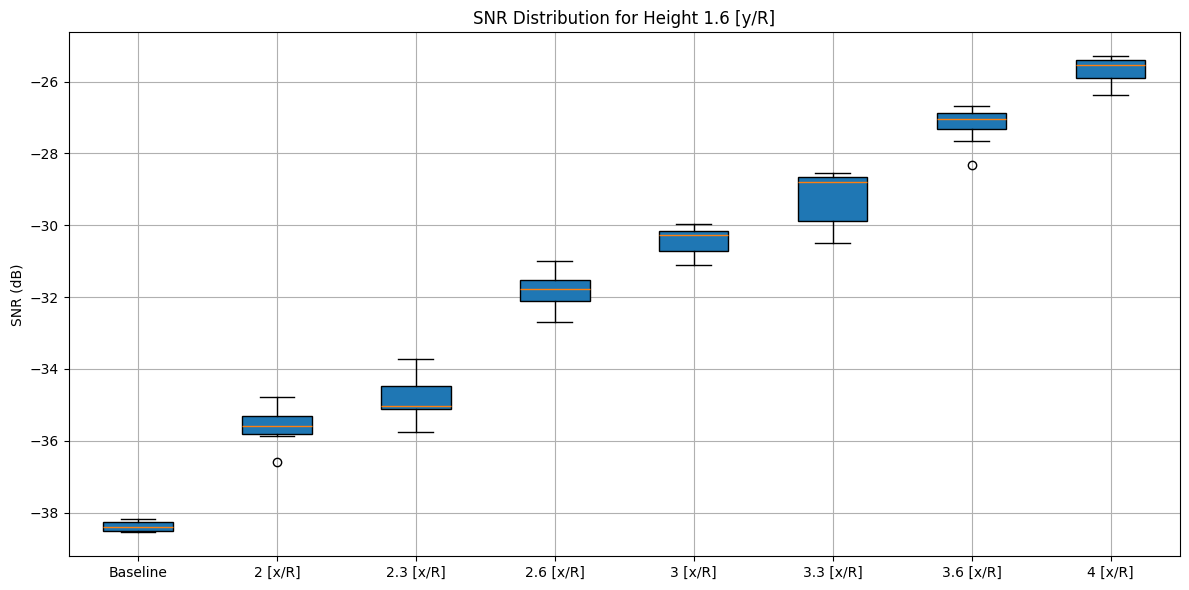

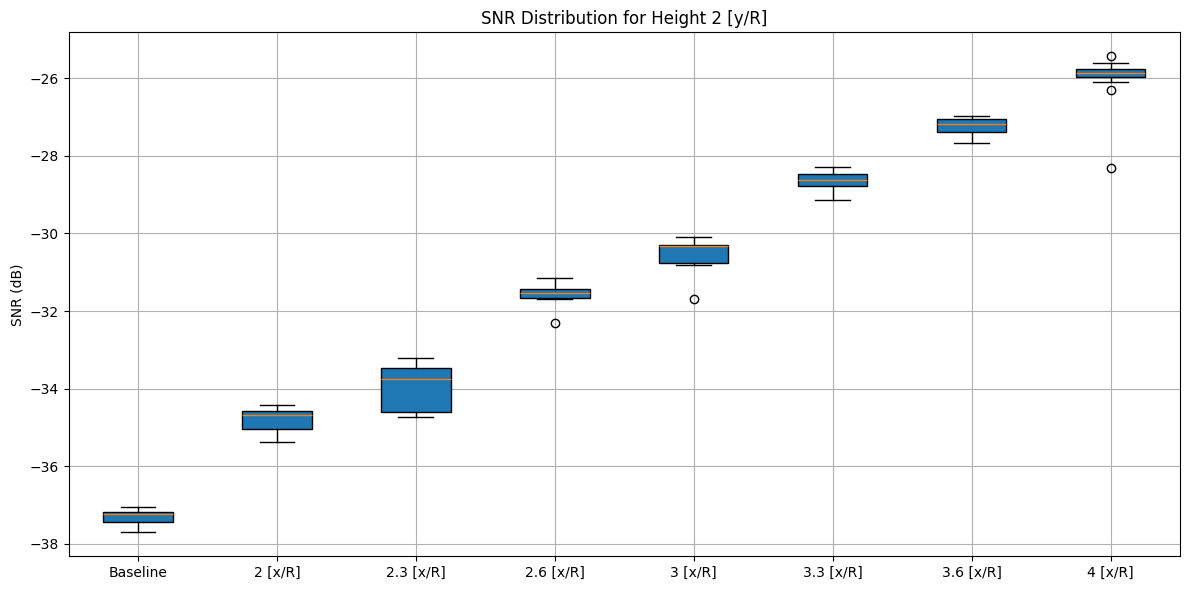

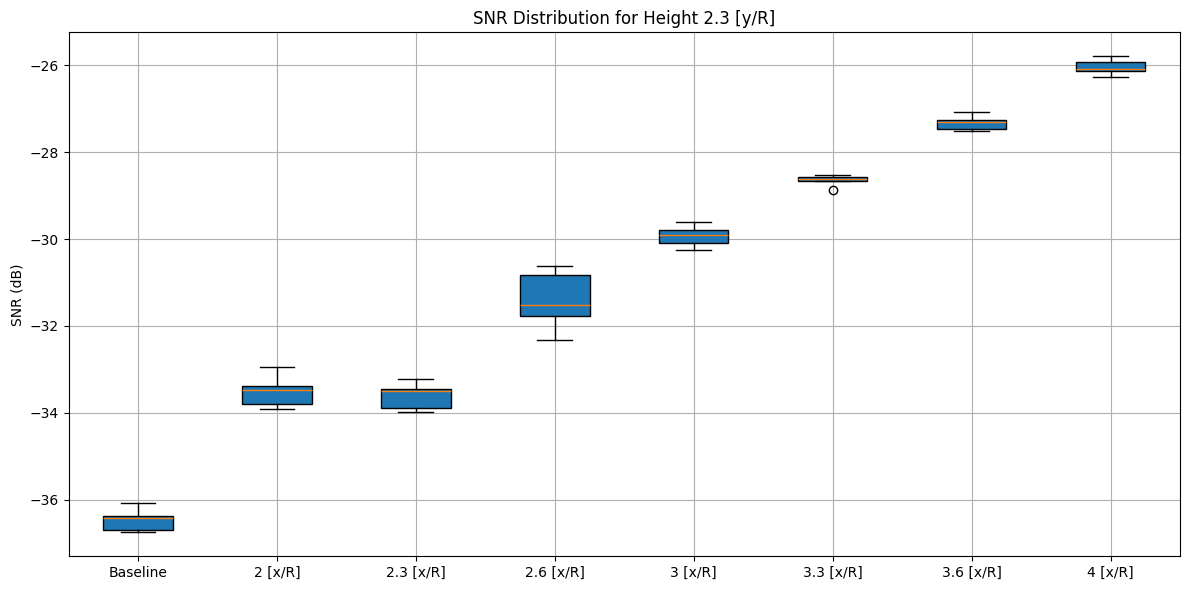

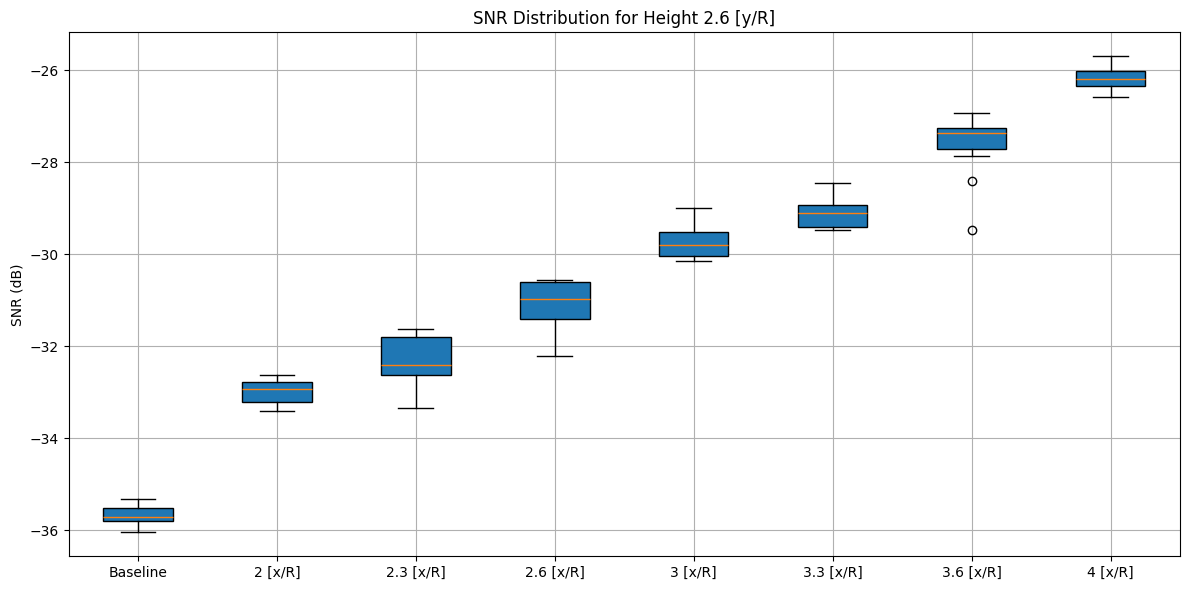

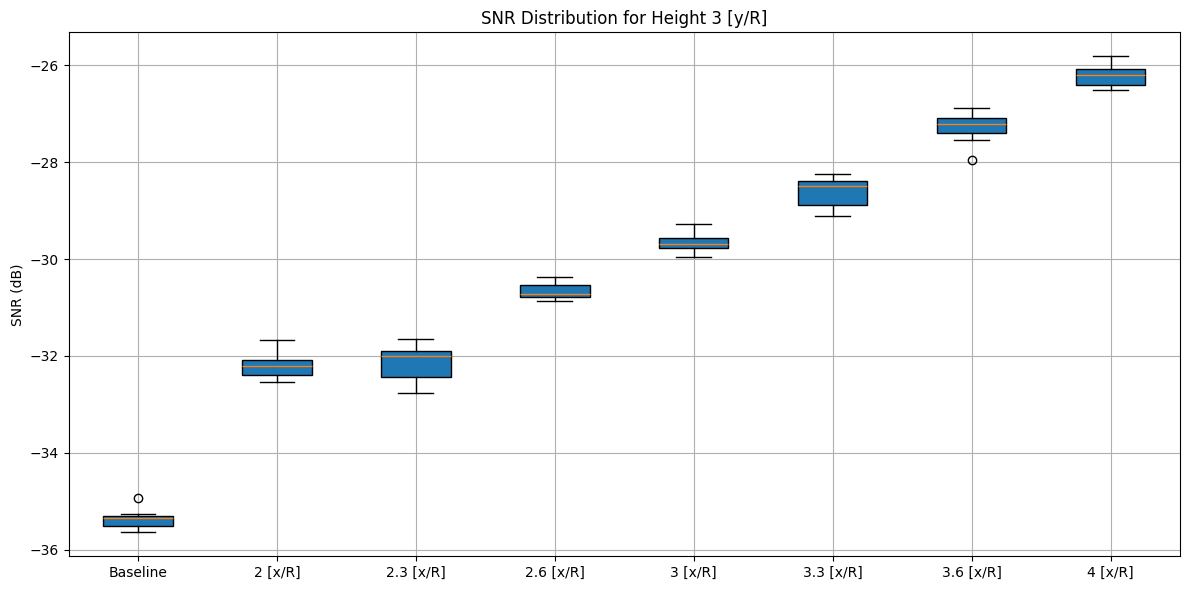

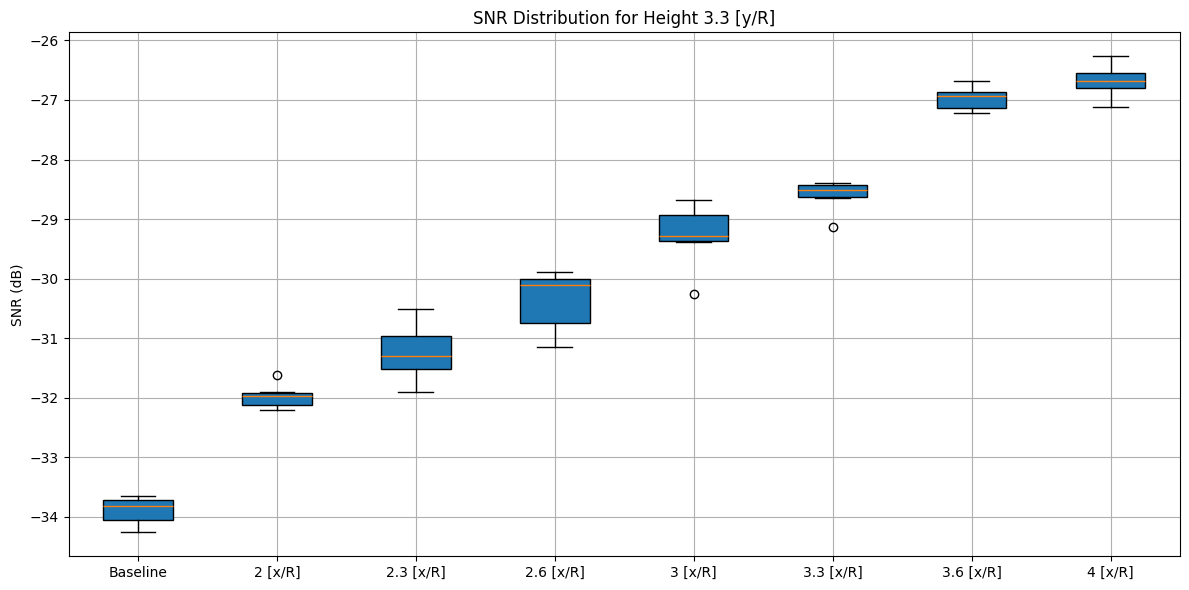

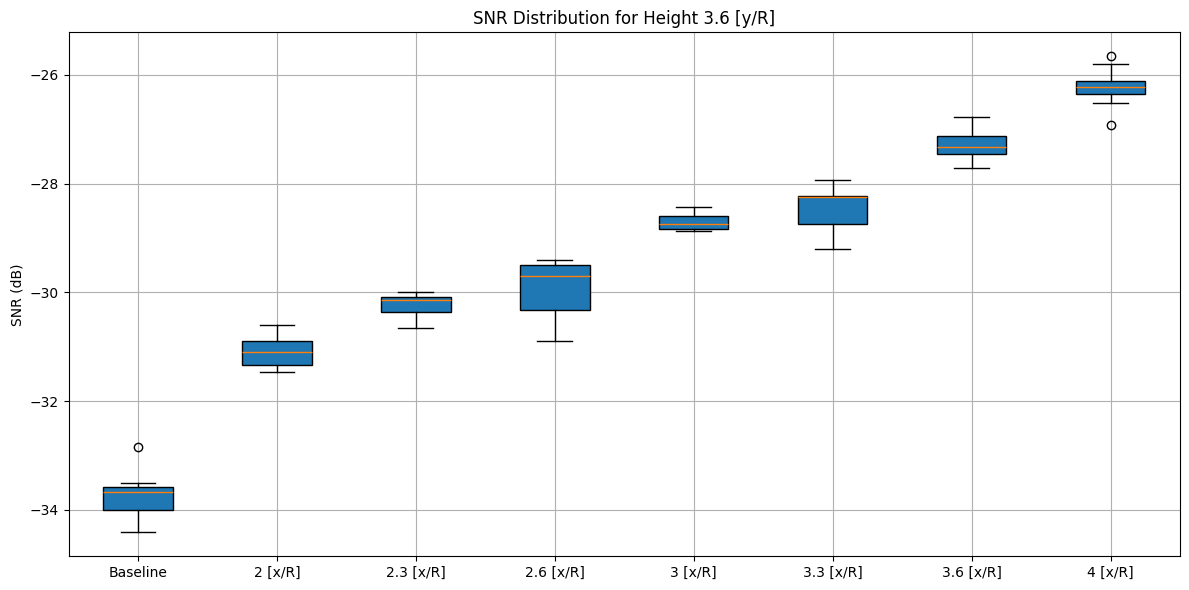

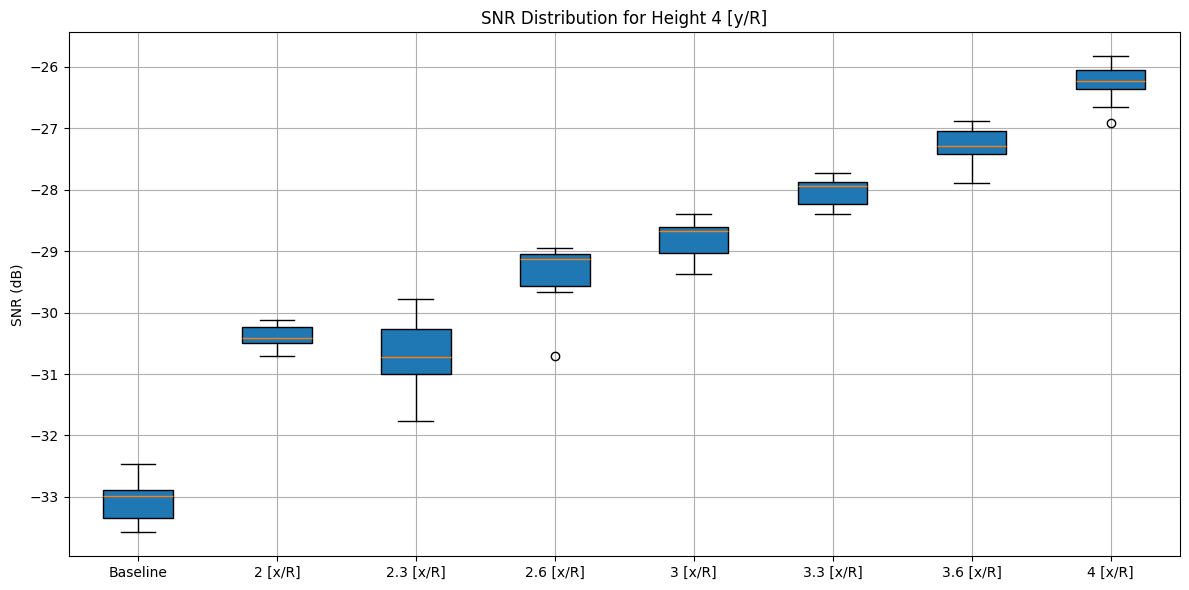

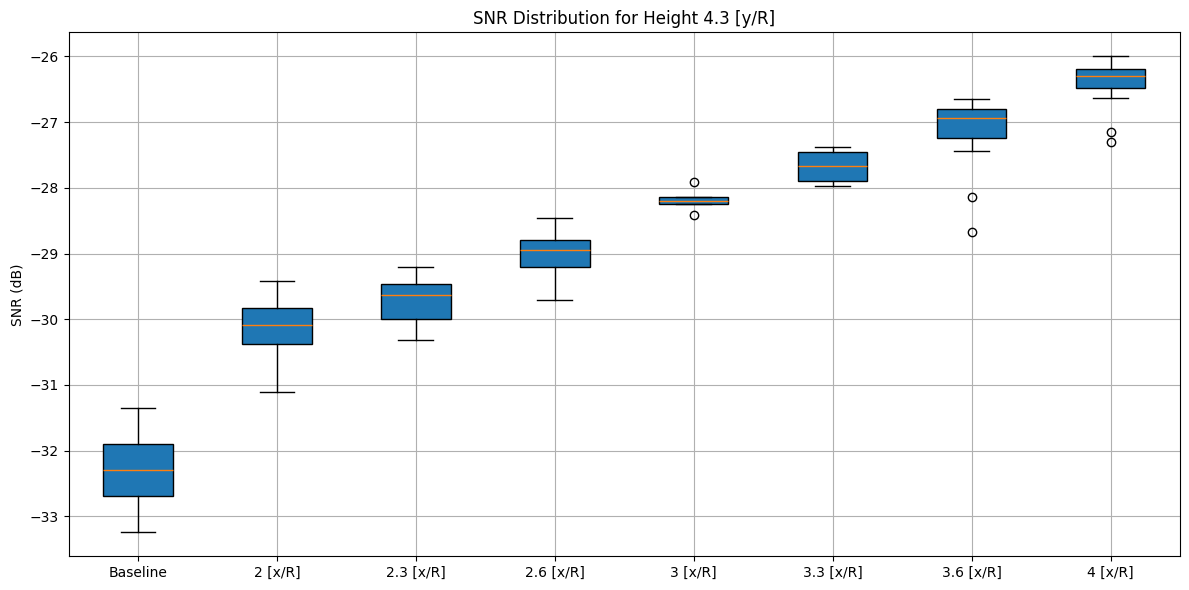

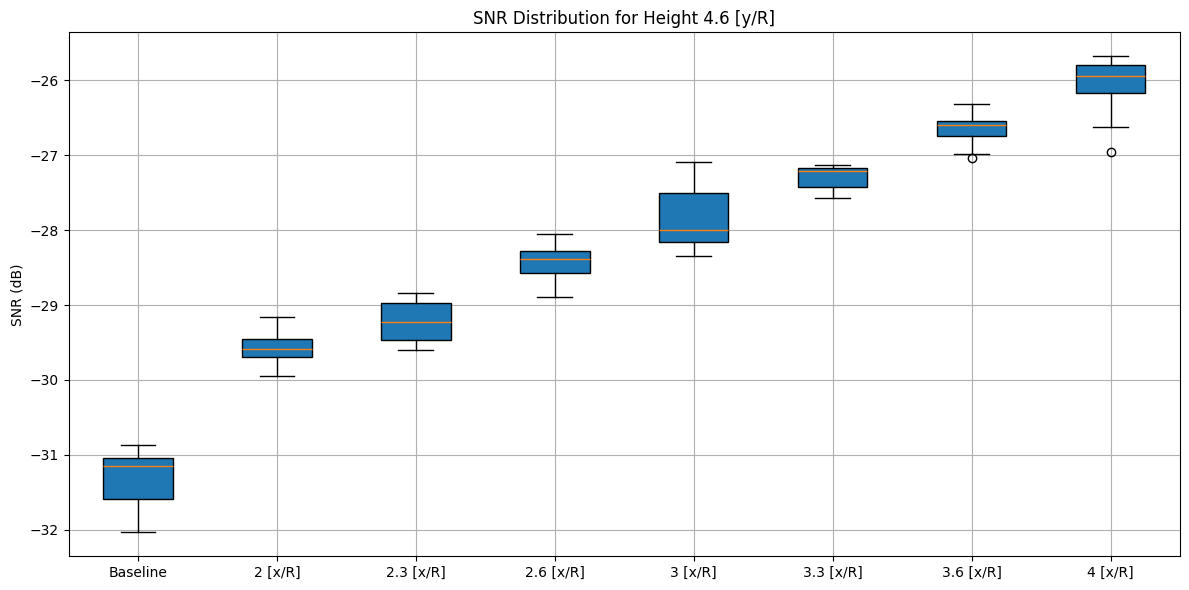

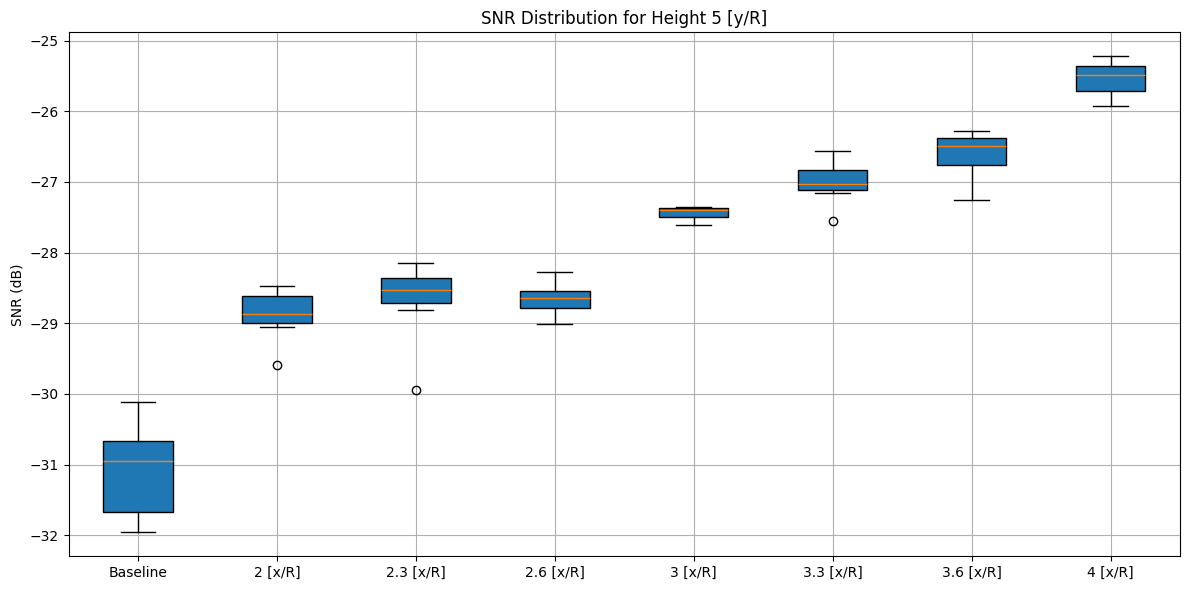

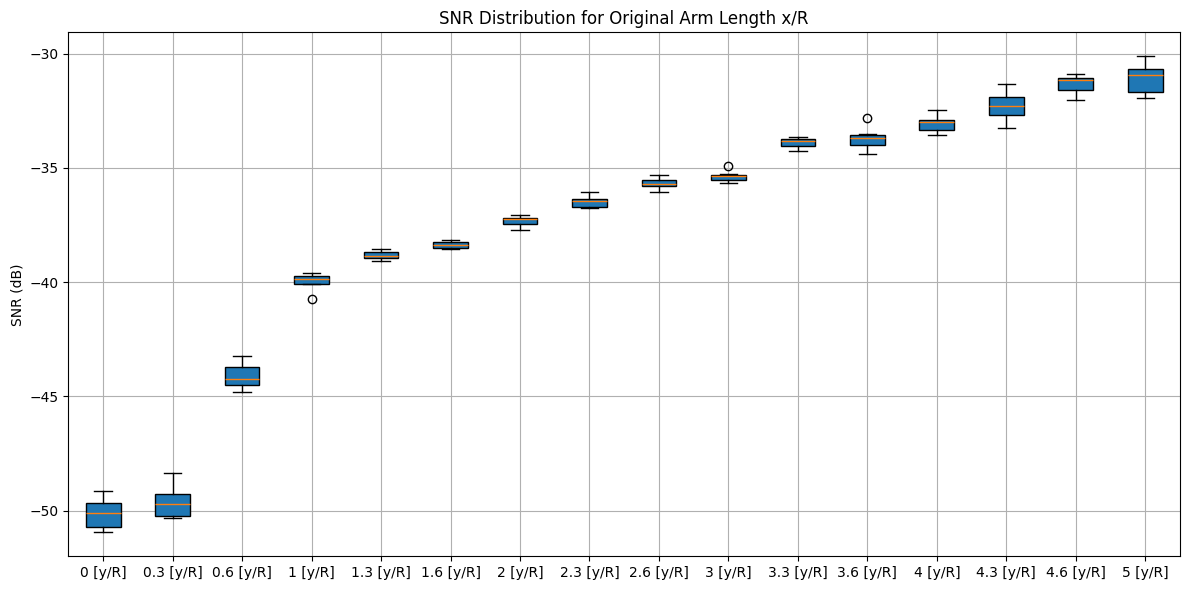

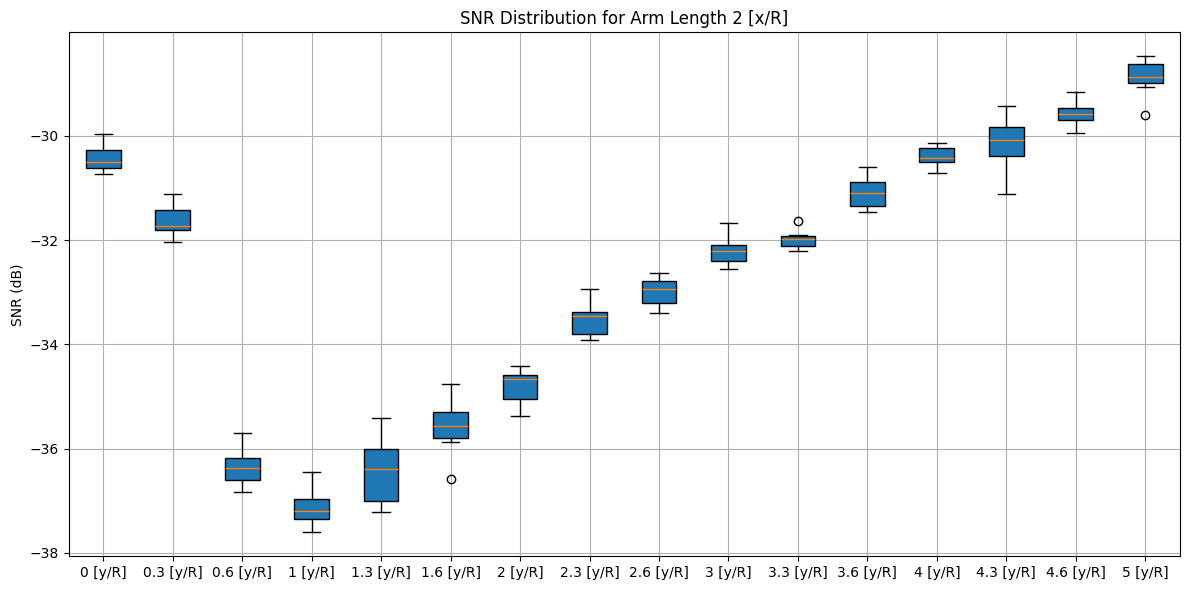

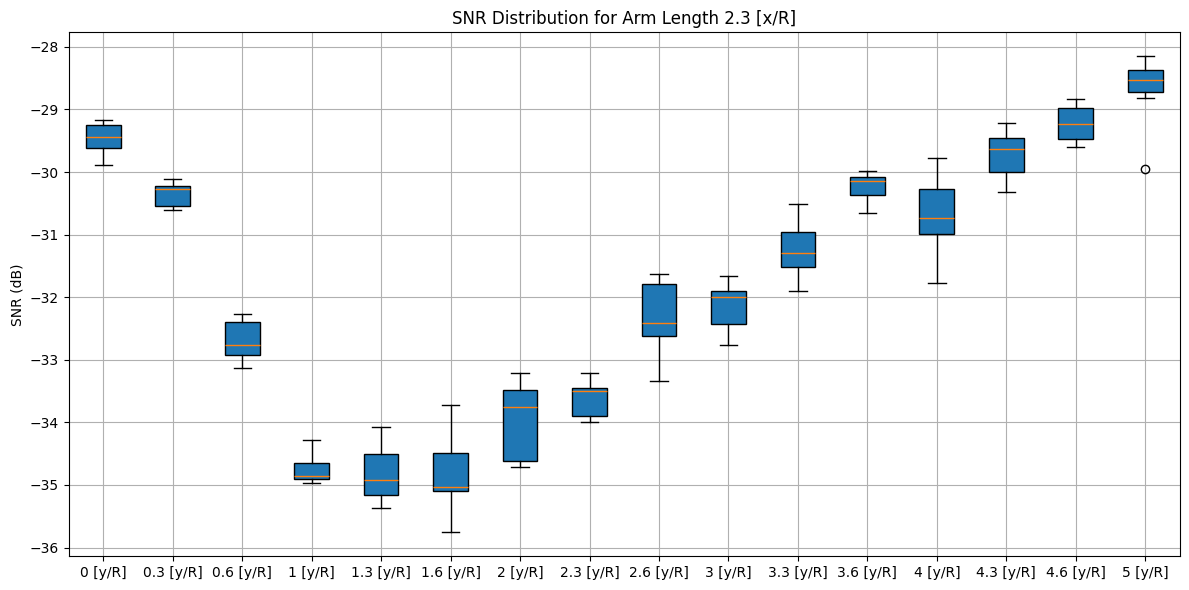

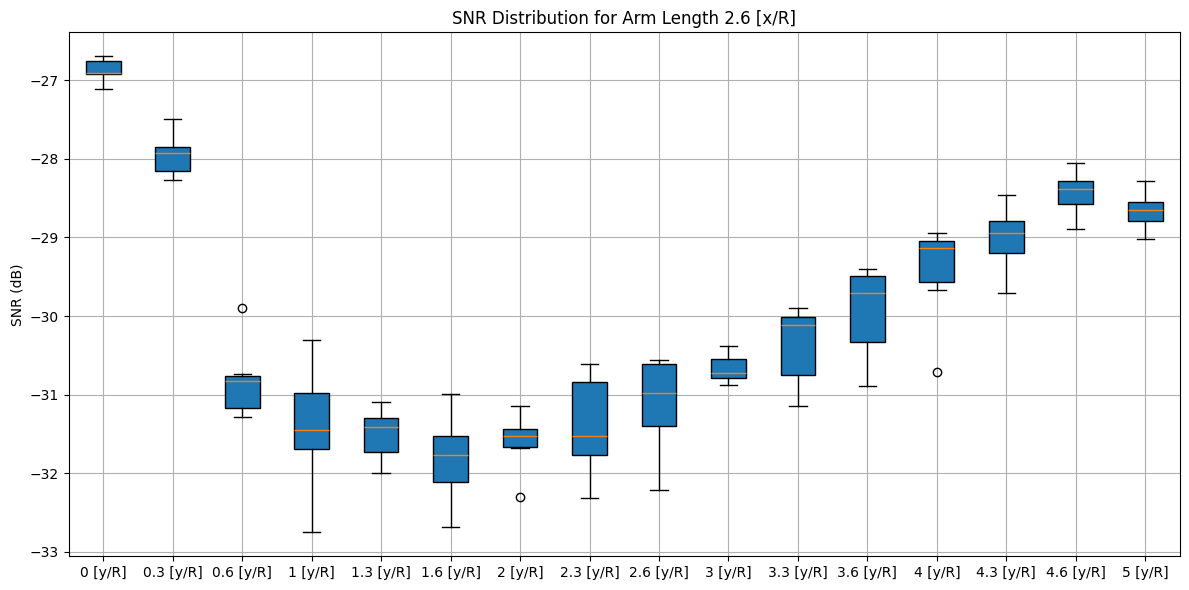

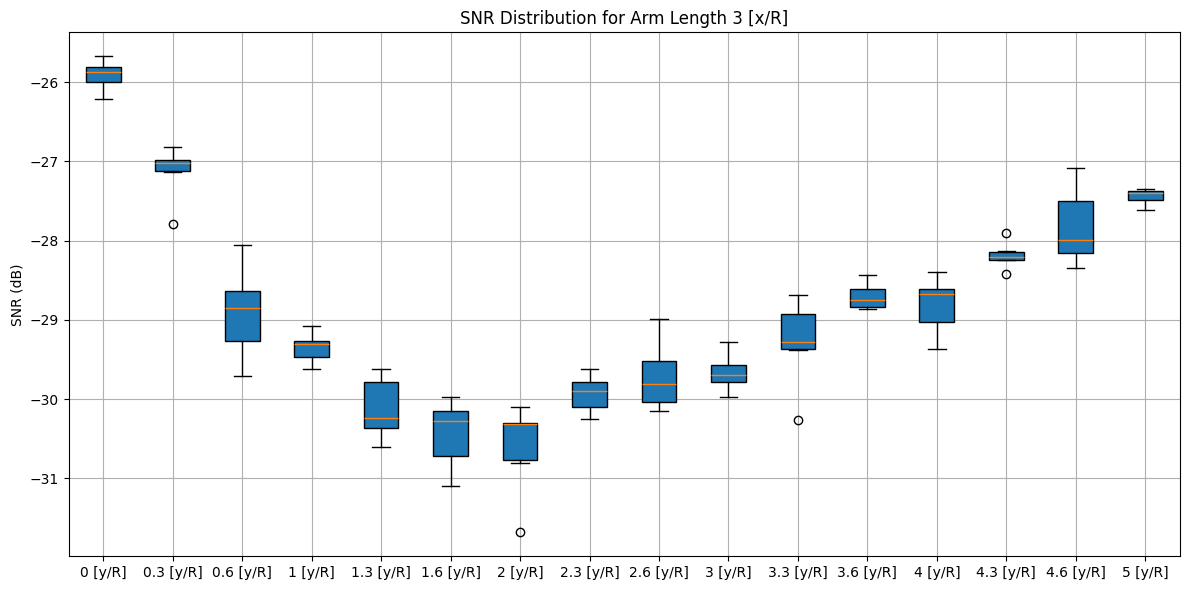

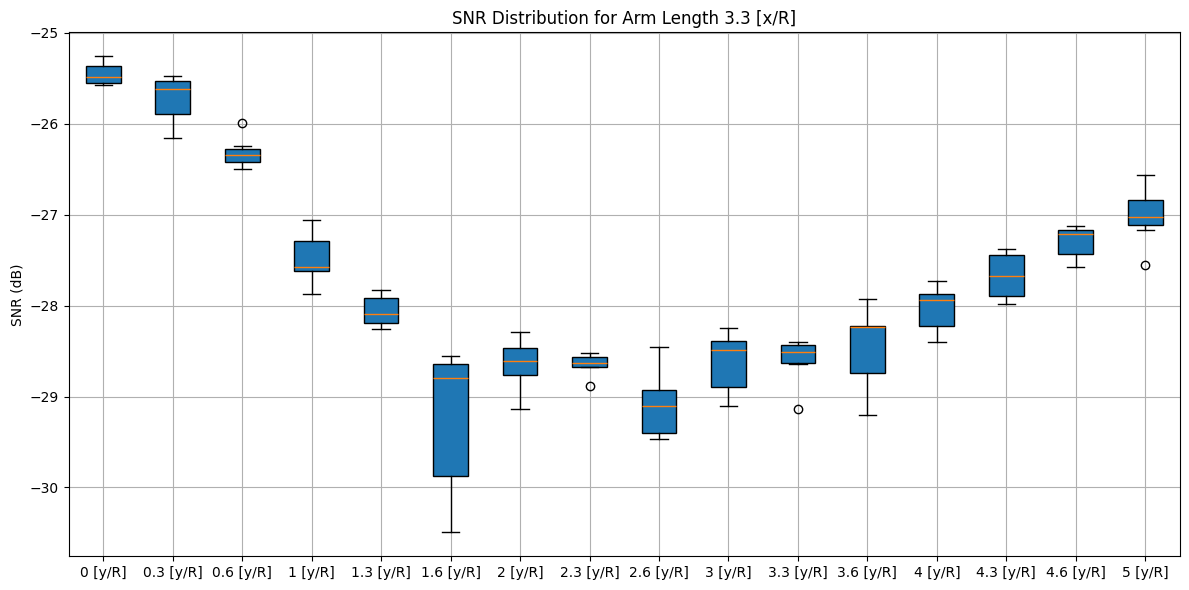

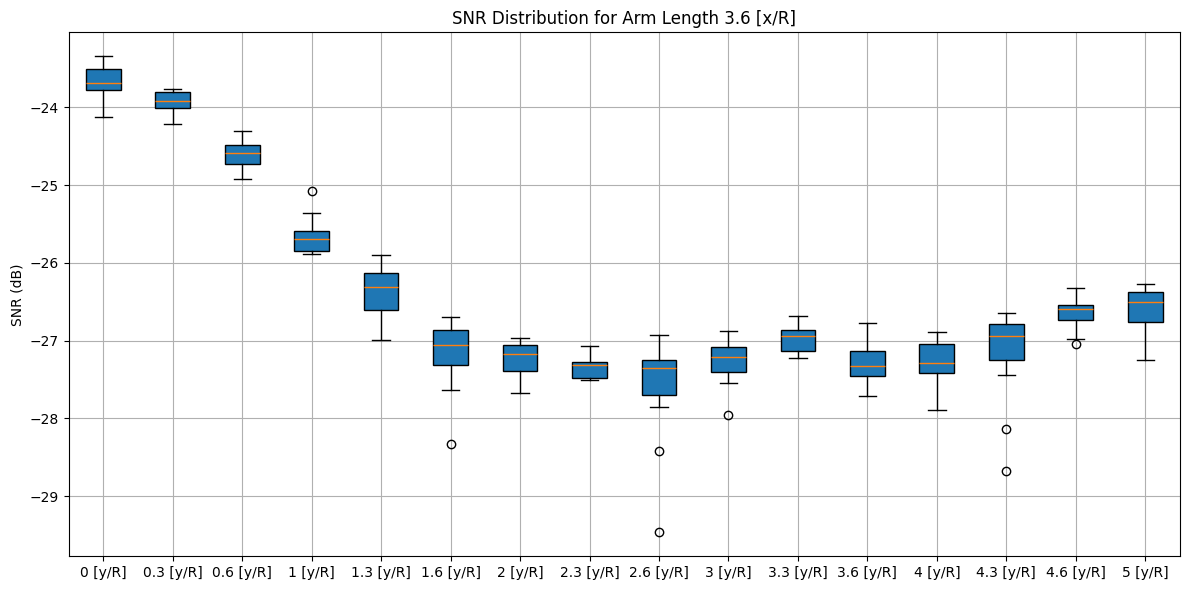

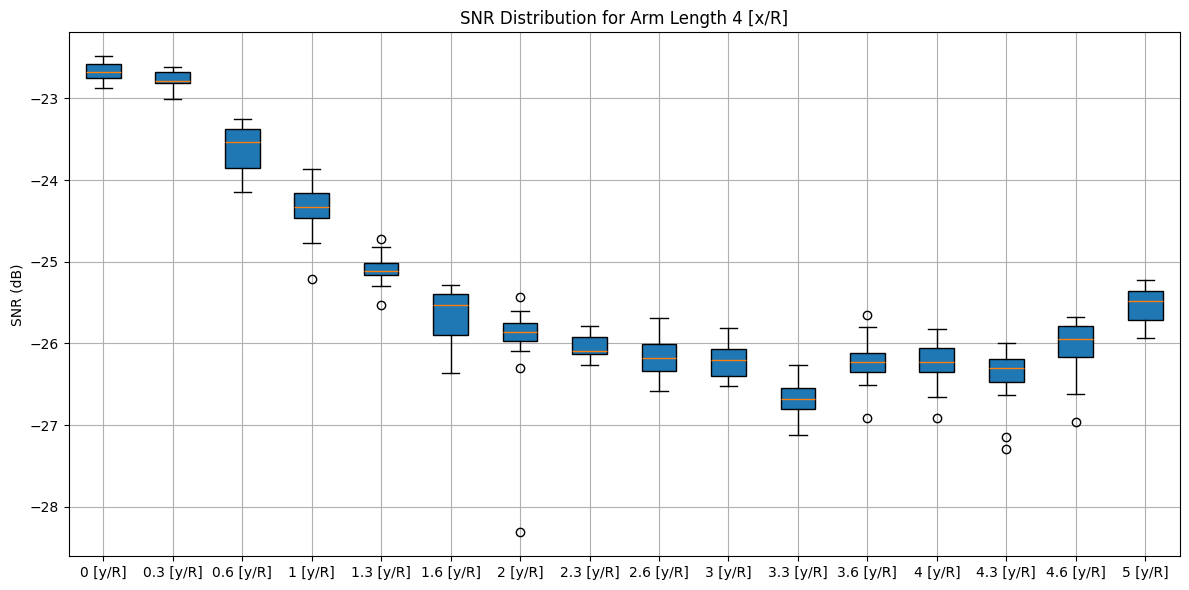

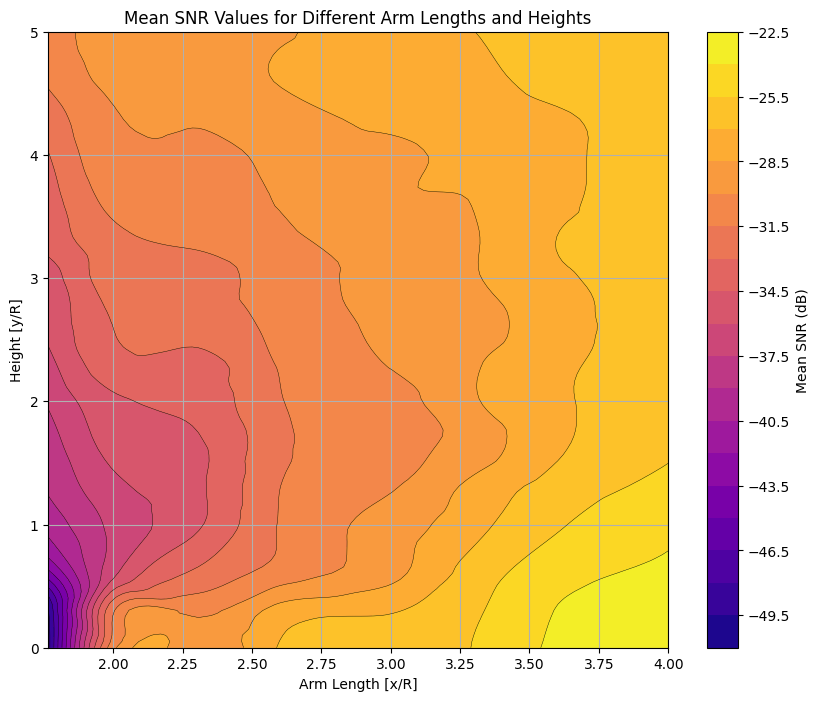

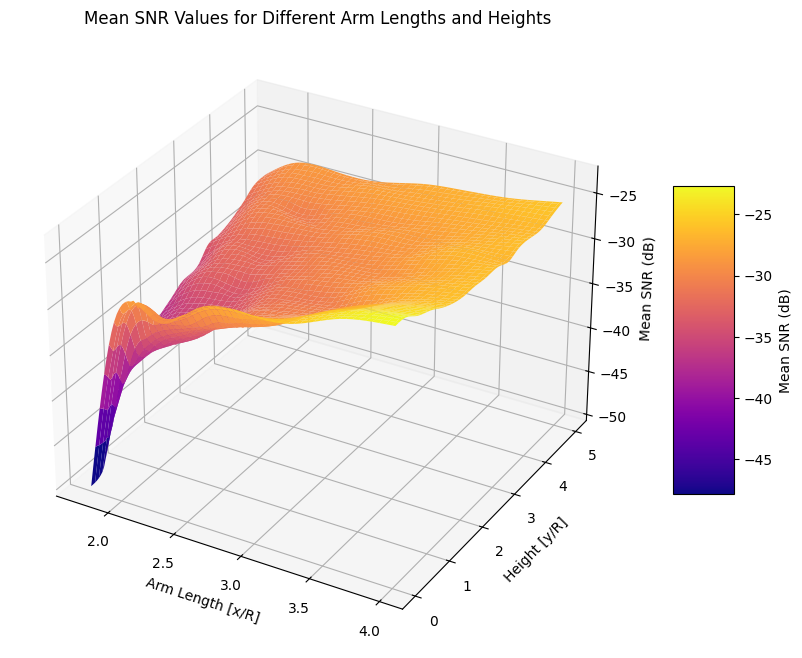

In [6]:
newfunc()

In [7]:

def plot_all_snrs_subfigs(all_snrs_by_arm, labels, title, show_plot=False, filepath=None):
    """Plot all SNR distributions for different arms as grouped boxplots in a single figure."""
    num_arms = len(all_snrs_by_arm)
    arm_lengths = list(all_snrs_by_arm.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each arm length
#colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    fig, ax = plt.subplots(figsize=(12, 8))

    positions = np.arange(1, len(labels) + 1)
    width = 0.5  # Width of each boxplot

    for i, arm_length in enumerate(arm_lengths):
        # Offset positions for each arm length
        offset_positions = positions + (i - num_arms / 2) * width
        # Boxplot for the current arm length
        bp = ax.boxplot(all_snrs_by_arm[arm_length], positions=positions, widths=width, patch_artist=True,
                        boxprops=dict(facecolor=colors[i], color=colors[i]),
                        capprops=dict(color=colors[i]),
                        whiskerprops=dict(color=colors[i]),
                        flierprops=dict(color=colors[i], markeredgecolor=colors[i]),
                        medianprops=dict(color='black'),
                        showfliers=False)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel("SNR (dB)")
    ax.set_ylim(-60, -15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Legend
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    legend_labels = [f'Arm {arm_length}' for arm_length in arm_lengths]
    ax.legend(legend_handles, legend_labels, title='Arm Length', loc='upper right')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if filepath:
        plt.savefig(filepath + title.replace(' ', '_').replace('/', '-') + ".png", dpi=300)
    if show_plot:
        plt.show()
    plt.close()

Processed 7 files for height 0 and original arm length
Processed 8 files for height 0 and arm length 2
Processed 8 files for height 0 and arm length 2.3
Processed 7 files for height 0 and arm length 2.6
Processed 7 files for height 0 and arm length 3
Processed 7 files for height 0 and arm length 3.3
Processed 11 files for height 0 and arm length 3.6
Processed 15 files for height 0 and arm length 4
Processed 7 files for height 0.3 and original arm length
Processed 7 files for height 0.3 and arm length 2
Processed 7 files for height 0.3 and arm length 2.3
Processed 7 files for height 0.3 and arm length 2.6
Processed 7 files for height 0.3 and arm length 3
Processed 7 files for height 0.3 and arm length 3.3
Processed 10 files for height 0.3 and arm length 3.6
Processed 15 files for height 0.3 and arm length 4
Processed 7 files for height 0.6 and original arm length
Processed 12 files for height 0.6 and arm length 2
Processed 7 files for height 0.6 and arm length 2.3
Processed 7 files for 

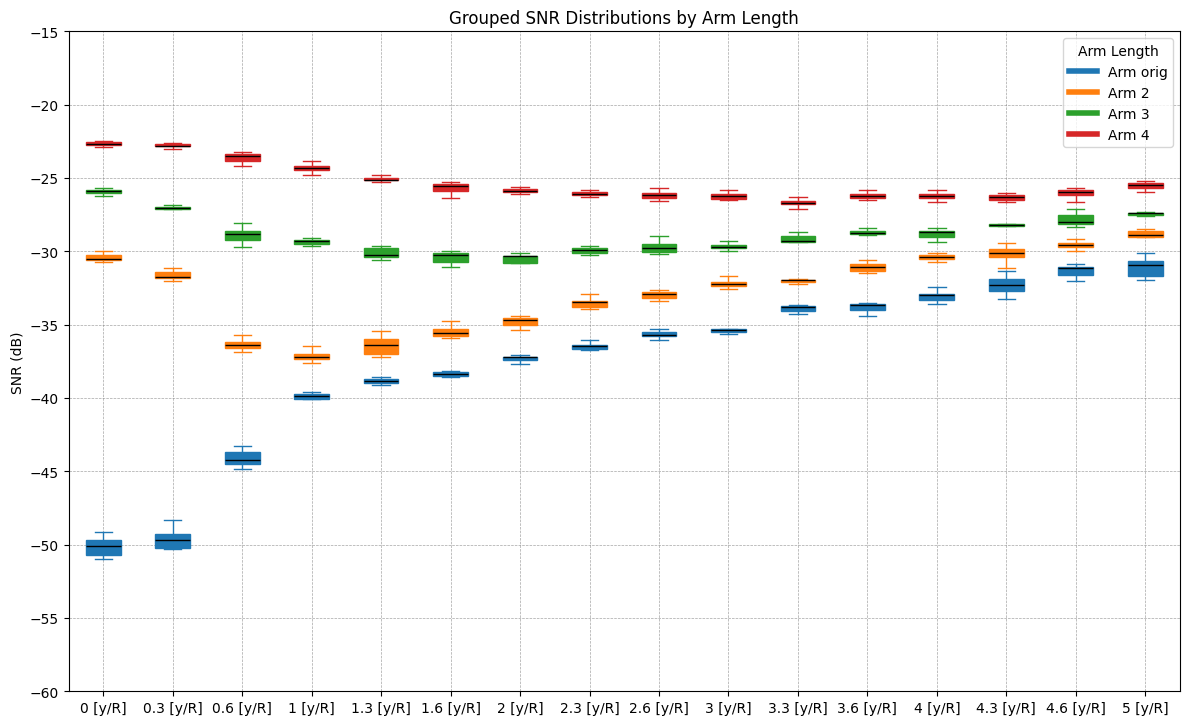

In [11]:

def newfunc_1():
    """
    Since im lazy, this function is the new version of the oldfunc() function. This will plot the recordings from 4th June 2024.
    """

    heights = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 3.3, 3.6, 4, 4.3, 4.6, 5]  # Heights to process
    distances = [2, 2.3, 2.6, 3, 3.3, 3.6, 4]
    labels_heights = [f"{height} [y/R]" for height in heights]  # Custom labels for each boxplot
    labels_distances = ['orig'] + [f"{distance} [x/R]" for distance in distances]

    snr_dict = {distance: {height: [] for height in heights} for distance in distances}
    snr_dict['orig'] = {height: [] for height in heights}

    clean_signal_directory = "Final_RECORDINGS/Final_Recordings_4Jun/Clean_Keywords/"

    for height in heights:
        # first process original arm length
        noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/ArmOrig/"
        snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
        snr_dict['orig'][height] = snrs
        print(f"Processed {len(snrs)} files for height {height} and original arm length")
        for distance in distances:
            try:
                noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/Arm{distance}/"
                snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
                snr_dict[distance][height] = snrs
                print(f"Processed {len(snrs)} files for height {height} and arm length {distance}")
            except Exception as e:
                print(f"Failed to process height {height} and arm length {distance}: {e}")

    # # Now we plot the SNR distributions
    # # First, plot the SNR distributions for each height, varying arm length

    # for height in heights:
    #     snrs = [snr_dict['orig'][height]] + [snr_dict[distance][height] for distance in distances]
    #     plot_all_snrs(snrs, labels_distances, f"SNR Distribution for Height {height} [y/R]", filepath="SNR_4Jun/")
    
    # # Next, plot the SNR distributions for each arm length, varying height
    # # first the original arm length
    # snrs = [snr_dict['orig'][height] for height in heights]
    # plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Original Arm Length x/R", filepath="SNR_4Jun/")
    # for distance in distances:
    #     snrs = [snr_dict[distance][height] for height in heights]
    #     plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Arm Length {distance} [x/R]", filepath="SNR_4Jun/")

    # # Finally, plot a heatmap of mean SNR values
    # plot_snr_contour(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Contour", filepath="SNR_4Jun/", show_plot=True)
    # plot_snr_surface(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Surface", filepath="SNR_4Jun/", show_plot=True)
    # plot_snr_heatmap(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Heatmap", filepath="SNR_4Jun/", show_plot=True)

    # Grouped boxplots for the specified arm lengths

    arm_lengths = ['orig', 2, 3, 4]
    all_snrs_by_arm = {}
    for arm_length in arm_lengths:
        if arm_length == 'orig':
            snrs = [snr_dict['orig'][height] for height in heights]
        else:
            snrs = [snr_dict[arm_length][height] for height in heights]
        all_snrs_by_arm[arm_length] = snrs
    
    plot_all_snrs_subfigs(all_snrs_by_arm, labels_heights, "Grouped SNR Distributions by Arm Length", filepath="SNR_4Jun/", show_plot=True)

if __name__ == "__main__":
    newfunc_1()

----------

In [13]:

def plot_all_snrs_subfigs_all0(all_snrs_by_arm, labels, title, show_plot=False, filepath=None):
    """Plot all SNR distributions for different arms as grouped boxplots in a single figure."""
    num_arms = len(all_snrs_by_arm)
    arm_lengths = list(all_snrs_by_arm.keys())
    #colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each arm length
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    fig, ax = plt.subplots(figsize=(12, 8))

    positions = np.arange(1, len(labels) + 1)
    width = 0.5  # Width of each boxplot

    for i, arm_length in enumerate(arm_lengths):
        # Offset positions for each arm length
        offset_positions = positions + (i - num_arms / 2) * width
        # Boxplot for the current arm length
        bp = ax.boxplot(all_snrs_by_arm[arm_length], positions=positions, widths=width, patch_artist=True,
                        boxprops=dict(facecolor=colors[i], color=colors[i]),
                        capprops=dict(color=colors[i]),
                        whiskerprops=dict(color=colors[i]),
                        flierprops=dict(color=colors[i], markeredgecolor=colors[i]),
                        medianprops=dict(color='black'),
                        showfliers=False)

    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.set_ylabel("SNR (dB)")
    ax.set_ylim(-60, -15)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Legend
    legend_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    legend_labels = [f'Arm {arm_length}' for arm_length in arm_lengths]
    ax.legend(legend_handles, legend_labels, title='Arm Length', loc='upper right')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if filepath:
        plt.savefig(filepath + title.replace(' ', '_').replace('/', '-') + ".png", dpi=300)
    if show_plot:
        plt.show()
    plt.close()

Processed 7 files for height 0 and original arm length
Processed 8 files for height 0 and arm length 2
Processed 8 files for height 0 and arm length 2.3
Processed 7 files for height 0 and arm length 2.6
Processed 7 files for height 0 and arm length 3
Processed 7 files for height 0 and arm length 3.3
Processed 11 files for height 0 and arm length 3.6
Processed 15 files for height 0 and arm length 4
Processed 7 files for height 0.3 and original arm length
Processed 7 files for height 0.3 and arm length 2
Processed 7 files for height 0.3 and arm length 2.3
Processed 7 files for height 0.3 and arm length 2.6
Processed 7 files for height 0.3 and arm length 3
Processed 7 files for height 0.3 and arm length 3.3
Processed 10 files for height 0.3 and arm length 3.6
Processed 15 files for height 0.3 and arm length 4
Processed 7 files for height 0.6 and original arm length
Processed 12 files for height 0.6 and arm length 2
Processed 7 files for height 0.6 and arm length 2.3
Processed 7 files for 

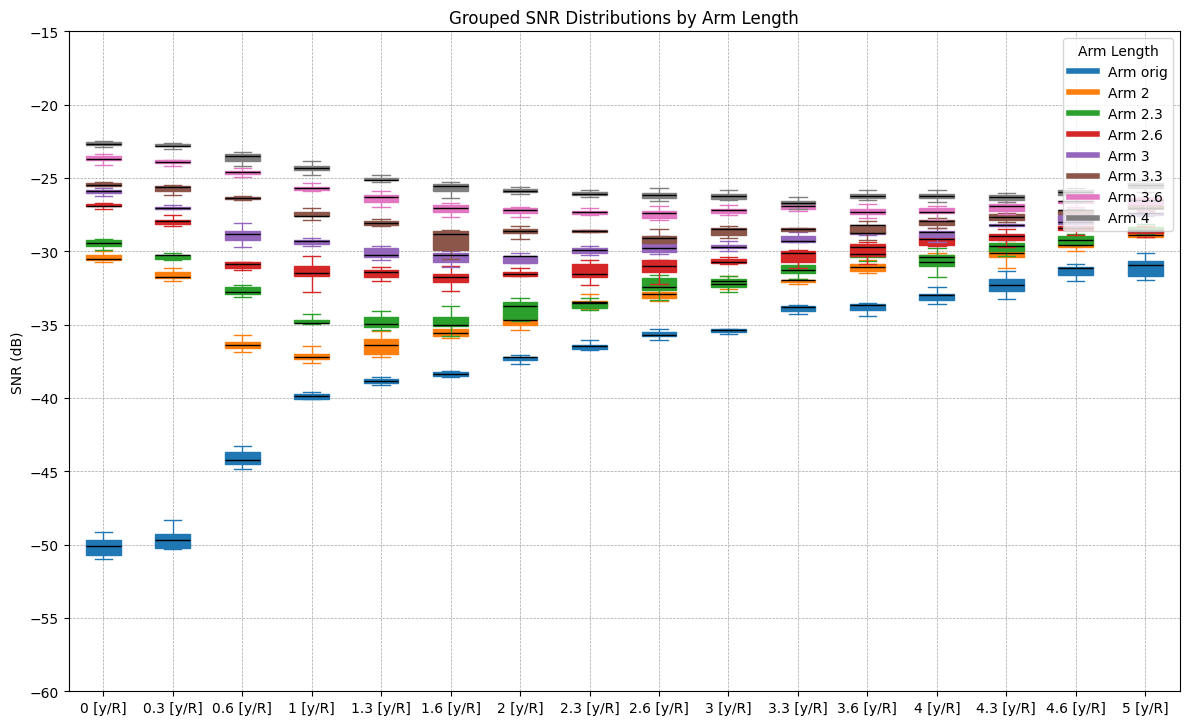

In [14]:

def newfunc_2():
    """
    Since im lazy, this function is the new version of the oldfunc() function. This will plot the recordings from 4th June 2024.
    """

    heights = [0, 0.3, 0.6, 1, 1.3, 1.6, 2, 2.3, 2.6, 3, 3.3, 3.6, 4, 4.3, 4.6, 5]  # Heights to process
    distances = [2, 2.3, 2.6, 3, 3.3, 3.6, 4]
    labels_heights = [f"{height} [y/R]" for height in heights]  # Custom labels for each boxplot
    labels_distances = ['orig'] + [f"{distance} [x/R]" for distance in distances]

    snr_dict = {distance: {height: [] for height in heights} for distance in distances}
    snr_dict['orig'] = {height: [] for height in heights}

    clean_signal_directory = "Final_RECORDINGS/Final_Recordings_4Jun/Clean_Keywords/"

    for height in heights:
        # first process original arm length
        noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/ArmOrig/"
        snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
        snr_dict['orig'][height] = snrs
        print(f"Processed {len(snrs)} files for height {height} and original arm length")
        for distance in distances:
            try:
                noisy_signals_directory = f"Final_RECORDINGS/Final_Recordings_4Jun/Height_{height}/Arm{distance}/"
                snrs, filenames = calculate_all_snrs(clean_signal_directory, noisy_signals_directory)
                snr_dict[distance][height] = snrs
                print(f"Processed {len(snrs)} files for height {height} and arm length {distance}")
            except Exception as e:
                print(f"Failed to process height {height} and arm length {distance}: {e}")

    # # Now we plot the SNR distributions
    # # First, plot the SNR distributions for each height, varying arm length

    # for height in heights:
    #     snrs = [snr_dict['orig'][height]] + [snr_dict[distance][height] for distance in distances]
    #     plot_all_snrs(snrs, labels_distances, f"SNR Distribution for Height {height} [y/R]", filepath="SNR_4Jun/")
    
    # # Next, plot the SNR distributions for each arm length, varying height
    # # first the original arm length
    # snrs = [snr_dict['orig'][height] for height in heights]
    # plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Original Arm Length x/R", filepath="SNR_4Jun/")
    # for distance in distances:
    #     snrs = [snr_dict[distance][height] for height in heights]
    #     plot_all_snrs(snrs, labels_heights, f"SNR Distribution for Arm Length {distance} [x/R]", filepath="SNR_4Jun/")

    # # Finally, plot a heatmap of mean SNR values
    # plot_snr_contour(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Contour", filepath="SNR_4Jun/", show_plot=True)
    # plot_snr_surface(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Surface", filepath="SNR_4Jun/", show_plot=True)
    # plot_snr_heatmap(snr_dict, "Mean SNR Values for Different Arm Lengths and Heights - Heatmap", filepath="SNR_4Jun/", show_plot=True)

    # Grouped boxplots for the specified arm lengths

    arm_lengths = ['orig', 2, 2.3, 2.6, 3, 3.3, 3.6, 4]
    all_snrs_by_arm = {}
    for arm_length in arm_lengths:
        if arm_length == 'orig':
            snrs = [snr_dict['orig'][height] for height in heights]
        else:
            snrs = [snr_dict[arm_length][height] for height in heights]
        all_snrs_by_arm[arm_length] = snrs
    
    plot_all_snrs_subfigs_all0(all_snrs_by_arm, labels_heights, "Grouped SNR Distributions by Arm Length", filepath="SNR_4Jun/", show_plot=True)

if __name__ == "__main__":
    newfunc_2()